# Introducing ML package of PySpark

## Predict chances of infant survival with ML

### Load the data

First, we load the data.

In [1]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
conf = SparkConf().setAppName("ML").setMaster("local[4]")

spark = SparkSession.builder.config(conf=conf).getOrCreate()
sc = spark.sparkContext

In [3]:
spark.conf.get("spark.sql.execution.arrow.enabled")

'false'

In [2]:
if spark.conf.get("spark.sql.execution.arrow.enabled") == 'true':
    spark.conf.set("spark.sql.execution.arrow.enabled", 'true')

In [5]:
import pyspark.sql.types as typ

labels = [
    ('INFANT_ALIVE_AT_REPORT', typ.IntegerType()),
    ('BIRTH_PLACE', typ.StringType()),
    ('MOTHER_AGE_YEARS', typ.IntegerType()),
    ('FATHER_COMBINED_AGE', typ.IntegerType()),
    ('CIG_BEFORE', typ.IntegerType()),
    ('CIG_1_TRI', typ.IntegerType()),
    ('CIG_2_TRI', typ.IntegerType()),
    ('CIG_3_TRI', typ.IntegerType()),
    ('MOTHER_HEIGHT_IN', typ.IntegerType()),
    ('MOTHER_PRE_WEIGHT', typ.IntegerType()),
    ('MOTHER_DELIVERY_WEIGHT', typ.IntegerType()),
    ('MOTHER_WEIGHT_GAIN', typ.IntegerType()),
    ('DIABETES_PRE', typ.IntegerType()),
    ('DIABETES_GEST', typ.IntegerType()),
    ('HYP_TENS_PRE', typ.IntegerType()),
    ('HYP_TENS_GEST', typ.IntegerType()),
    ('PREV_BIRTH_PRETERM', typ.IntegerType())
]

schema = typ.StructType([
    typ.StructField(e[0], e[1], False) for e in labels
])

births = spark.read.csv("births_transformed.csv.gz", header=True, schema=schema)

In [13]:
births

DataFrame[INFANT_ALIVE_AT_REPORT: int, BIRTH_PLACE: string, MOTHER_AGE_YEARS: int, FATHER_COMBINED_AGE: int, CIG_BEFORE: int, CIG_1_TRI: int, CIG_2_TRI: int, CIG_3_TRI: int, MOTHER_HEIGHT_IN: int, MOTHER_PRE_WEIGHT: int, MOTHER_DELIVERY_WEIGHT: int, MOTHER_WEIGHT_GAIN: int, DIABETES_PRE: int, DIABETES_GEST: int, HYP_TENS_PRE: int, HYP_TENS_GEST: int, PREV_BIRTH_PRETERM: int]

In [15]:
births.select("INFANT_ALIVE_AT_REPORT", "BIRTH_PLACE").show(5)

+----------------------+-----------+
|INFANT_ALIVE_AT_REPORT|BIRTH_PLACE|
+----------------------+-----------+
|                     0|          1|
|                     0|          1|
|                     0|          1|
|                     0|          1|
|                     0|          1|
+----------------------+-----------+
only showing top 5 rows



In [68]:
births.count()

45429

### Create transformers

In [6]:
# 将BIRTH_PLACE 转为int类型
import pyspark.ml.feature as ft

births = births.withColumn('BIRTH_PLACE_INT',
                           births['BIRTH_PLACE'].cast(typ.IntegerType()))
births

DataFrame[INFANT_ALIVE_AT_REPORT: int, BIRTH_PLACE: string, MOTHER_AGE_YEARS: int, FATHER_COMBINED_AGE: int, CIG_BEFORE: int, CIG_1_TRI: int, CIG_2_TRI: int, CIG_3_TRI: int, MOTHER_HEIGHT_IN: int, MOTHER_PRE_WEIGHT: int, MOTHER_DELIVERY_WEIGHT: int, MOTHER_WEIGHT_GAIN: int, DIABETES_PRE: int, DIABETES_GEST: int, HYP_TENS_PRE: int, HYP_TENS_GEST: int, PREV_BIRTH_PRETERM: int, BIRTH_PLACE_INT: int]

Having done this, we can now create our first `Transformer`.

In [58]:
# BIRTH_PLACE 使用one-hot
encoder = ft.OneHotEncoder(inputCol='BIRTH_PLACE_INT', outputCol='BIRTH_PLACE_VEC')


In [23]:
encoder.getOutputCol()

'BIRTH_PLACE_VEC'

Let's now create a single column with all the features collated together. 

In [59]:
# merges multiple columns into a vector column
features_creator = ft.VectorAssembler(
    inputCols=[col[0] for col in labels[2:]]+[encoder.getOutputCol()],  # 特征字段, 包括onehot转换后的birth_place
    outputCol="features"  # 整合成为一个features 向量 
)

### Create an estimator

In this example we will (once again) us the Logistic Regression model.

In [56]:
import pyspark.ml.classification as cl

Once loaded, let's create the model.

In [8]:
# 指定 y 为 df 的INFANT_ALIVE_AT_REPORT列
# 特征列的名字上面指定为features了, 否则使用getOutputCol
logistic = cl.LogisticRegression(
    maxIter=10,
    regParam=0.01, 
    labelCol='INFANT_ALIVE_AT_REPORT'  # 如果列名为label 不需要手动指定了
    ) 

### Create a pipeline

All that is left now is to creat a `Pipeline` and fit the model. First, let's load the `Pipeline` from the package.

In [7]:
# 创建pipeline
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[encoder, features_creator, logistic])

NameError: name 'encoder' is not defined

### Fit the model

Conventiently, `DataFrame` API has the `.randomSplit(...)` method.

In [69]:
births_train, births_test = births \
    .randomSplit([0.7, 0.3], seed=0)

In [70]:
births_train.count(), births_test.count()

(31868, 13561)

Now run our `pipeline` and estimate our model.

In [29]:
model = pipeline.fit(births_train)
model

PipelineModel_82c48b352659

In [31]:
test_model = model.transform(births_test)

In [50]:
test_model

DataFrame[INFANT_ALIVE_AT_REPORT: int, BIRTH_PLACE: string, MOTHER_AGE_YEARS: int, FATHER_COMBINED_AGE: int, CIG_BEFORE: int, CIG_1_TRI: int, CIG_2_TRI: int, CIG_3_TRI: int, MOTHER_HEIGHT_IN: int, MOTHER_PRE_WEIGHT: int, MOTHER_DELIVERY_WEIGHT: int, MOTHER_WEIGHT_GAIN: int, DIABETES_PRE: int, DIABETES_GEST: int, HYP_TENS_PRE: int, HYP_TENS_GEST: int, PREV_BIRTH_PRETERM: int, BIRTH_PLACE_INT: int, BIRTH_PLACE_VEC: vector, features: vector, rawPrediction: vector, probability: vector, prediction: double]

Here's what the `test_model` looks like.

In [40]:
test_model.take(1)

[Row(INFANT_ALIVE_AT_REPORT=0, BIRTH_PLACE='1', MOTHER_AGE_YEARS=13, FATHER_COMBINED_AGE=99, CIG_BEFORE=0, CIG_1_TRI=0, CIG_2_TRI=0, CIG_3_TRI=0, MOTHER_HEIGHT_IN=66, MOTHER_PRE_WEIGHT=133, MOTHER_DELIVERY_WEIGHT=135, MOTHER_WEIGHT_GAIN=2, DIABETES_PRE=0, DIABETES_GEST=0, HYP_TENS_PRE=0, HYP_TENS_GEST=0, PREV_BIRTH_PRETERM=0, BIRTH_PLACE_INT=1, BIRTH_PLACE_VEC=SparseVector(9, {1: 1.0}), features=SparseVector(24, {0: 13.0, 1: 99.0, 6: 66.0, 7: 133.0, 8: 135.0, 9: 2.0, 16: 1.0}), rawPrediction=DenseVector([1.0573, -1.0573]), probability=DenseVector([0.7422, 0.2578]), prediction=0.0)]

In [41]:
import numpy as np
1./(1. + np.exp(1.0573))

0.2578257662121432

In [42]:
1./(1. + np.exp(-1.0573))

0.7421742337878569

### Model performance

Obviously, we would like to now test how well our model did.

In [62]:
import pyspark.ml.evaluation as ev

# 指定 y_predict 和 y_label 为哪一列
evaluator = ev.BinaryClassificationEvaluator(
    rawPredictionCol='probability',  # 也可以是 rawPrediction
    labelCol='INFANT_ALIVE_AT_REPORT')
evaluator.metricName

Param(parent='BinaryClassificationEvaluator_61c4a2063b79', name='metricName', doc='metric name in evaluation (areaUnderROC|areaUnderPR)')

In [46]:
evaluator.evaluate(test_model, 
                  {evaluator.metricName: 'areaUnderROC'})  # AUC

0.7401301847095617

In [47]:
evaluator.evaluate(test_model,
                   {evaluator.metricName: 'areaUnderPR'})  # Average precision (AP)

0.7139354342365674

### Saving the model

PySpark allows you to save the `Pipeline` definition for later use.

In [48]:
# 保存pipeline
pipeline_path = '.infant_oneHotEncoder_Logistic_Pipeline'
# overwrite 模型已存在时 进行覆盖
pipeline.write().overwrite().save(pipeline_path)

So, you can load it up later and use straight away to `.fit(...)` and predict.

In [49]:
# 加载
new_pipeline = Pipeline.load(pipeline_pat)
new_pipeline.fit(births_train).transform(births_test).take(1)

[Row(INFANT_ALIVE_AT_REPORT=0, BIRTH_PLACE='1', MOTHER_AGE_YEARS=13, FATHER_COMBINED_AGE=99, CIG_BEFORE=0, CIG_1_TRI=0, CIG_2_TRI=0, CIG_3_TRI=0, MOTHER_HEIGHT_IN=66, MOTHER_PRE_WEIGHT=133, MOTHER_DELIVERY_WEIGHT=135, MOTHER_WEIGHT_GAIN=2, DIABETES_PRE=0, DIABETES_GEST=0, HYP_TENS_PRE=0, HYP_TENS_GEST=0, PREV_BIRTH_PRETERM=0, BIRTH_PLACE_INT=1, BIRTH_PLACE_VEC=SparseVector(9, {1: 1.0}), features=SparseVector(24, {0: 13.0, 1: 99.0, 6: 66.0, 7: 133.0, 8: 135.0, 9: 2.0, 16: 1.0}), rawPrediction=DenseVector([1.0573, -1.0573]), probability=DenseVector([0.7422, 0.2578]), prediction=0.0)]

You can also save the whole model

In [52]:
# 保存训练好的PipelineModel
from pyspark.ml import PipelineModel

model_path = './infant_oneHotEncoder_Logistic_PipelineModel'
model.write().overwrite().save(model_path)

loaded_model = PipelineModel.load(model_path)
test_res = loaded_model.transform(births_test)
test_res.take(1)

[Row(INFANT_ALIVE_AT_REPORT=0, BIRTH_PLACE='1', MOTHER_AGE_YEARS=13, FATHER_COMBINED_AGE=99, CIG_BEFORE=0, CIG_1_TRI=0, CIG_2_TRI=0, CIG_3_TRI=0, MOTHER_HEIGHT_IN=66, MOTHER_PRE_WEIGHT=133, MOTHER_DELIVERY_WEIGHT=135, MOTHER_WEIGHT_GAIN=2, DIABETES_PRE=0, DIABETES_GEST=0, HYP_TENS_PRE=0, HYP_TENS_GEST=0, PREV_BIRTH_PRETERM=0, BIRTH_PLACE_INT=1, BIRTH_PLACE_VEC=SparseVector(9, {1: 1.0}), features=SparseVector(24, {0: 13.0, 1: 99.0, 6: 66.0, 7: 133.0, 8: 135.0, 9: 2.0, 16: 1.0}), rawPrediction=DenseVector([1.0573, -1.0573]), probability=DenseVector([0.7422, 0.2578]), prediction=0.0)]

## Parameter hyper-tuning

### Grid search

Load the `.tuning` part of the package.

In [11]:
import pyspark.ml.tuning as tune

Next let's specify our model and the list of parameters we want to loop through.

In [12]:
logistic = cl.LogisticRegression(labelCol='INFANT_ALIVE_AT_REPORT')
# grid search
grid = tune.ParamGridBuilder().\
    addGrid(logistic.maxIter, [5, 10, 50]).\
    addGrid(logistic.regParam, [0.01, 0.05, 0.1, 0.3]).\
    build()
grid

[{Param(parent='LogisticRegression_8386ed87a5e7', name='maxIter', doc='max number of iterations (>= 0).'): 5,
  Param(parent='LogisticRegression_8386ed87a5e7', name='regParam', doc='regularization parameter (>= 0).'): 0.01},
 {Param(parent='LogisticRegression_8386ed87a5e7', name='maxIter', doc='max number of iterations (>= 0).'): 5,
  Param(parent='LogisticRegression_8386ed87a5e7', name='regParam', doc='regularization parameter (>= 0).'): 0.05},
 {Param(parent='LogisticRegression_8386ed87a5e7', name='maxIter', doc='max number of iterations (>= 0).'): 5,
  Param(parent='LogisticRegression_8386ed87a5e7', name='regParam', doc='regularization parameter (>= 0).'): 0.1},
 {Param(parent='LogisticRegression_8386ed87a5e7', name='maxIter', doc='max number of iterations (>= 0).'): 5,
  Param(parent='LogisticRegression_8386ed87a5e7', name='regParam', doc='regularization parameter (>= 0).'): 0.3},
 {Param(parent='LogisticRegression_8386ed87a5e7', name='maxIter', doc='max number of iterations (>= 0)

Next, we need some way of comparing the models.

In [24]:
evaluator = ev.BinaryClassificationEvaluator(
    rawPredictionCol="probability",
    labelCol='INFANT_ALIVE_AT_REPORT',
    metricName='areaUnderROC'
    )

Create the logic that will do the validation work for us.

In [14]:
# 默认 k = 3 
cv = tune.CrossValidator(  
    estimator=logistic,
    estimatorParamMaps=grid,
    evaluator=evaluator
)


Create a purely transforming `Pipeline`.

In [52]:
# pipeline 做数据转换
pipeline = Pipeline(stages=[encoder, features_creator])

data_transformer = pipeline.fit(births_train)

Having done this, we are ready to find the optimal combination of parameters for our model.

In [53]:
cv_model = cv.fit(data_transformer.transform(births_train))
# 返回最佳估计模型

In [39]:
cv_model

CrossValidatorModel_ba9236034f5a

The `cvModel` will return the best model estimated. We can now use it to see if it performed better than our previous model.

In [34]:
data_train = data_transformer \
    .transform(births_test)
results = cv_model.transform(data_train)

print(evaluator.evaluate(results, 
     {evaluator.metricName: 'areaUnderROC'}))
print(evaluator.evaluate(results, 
     {evaluator.metricName: 'areaUnderPR'}))

0.7403373658139272
0.7208981778954524


In [71]:
cv_pipeline = Pipeline(stages=[data_transformer, cv])
cv_pipeline_model = cv_pipeline.fit(births_train)

In [73]:
results_test = cv_pipeline_model.transform(births_train)

evaluator.evaluate(results_test)
# print(evaluator.evaluate(results, 
#      {evaluator.metricName: 'areaUnderROC'}))
# print(evaluator.evaluate(results, 
#      {evaluator.metricName: 'areaUnderPR'}))

0.7388079741570979

In [73]:
cv_pipeline_model.stages[2]

CrossValidatorModel_b0560c3cd612

In [30]:
sc

<SparkContext master=local[4] appName=ML>

What parameters has the best model? The answer is a little bit convoluted but here's how you can extract it.

In [74]:
results = [
    (
        [
            {key.name: paramValue} 
            for key, paramValue 
            in zip(
                params.keys(), 
                params.values())
        ], metric
    ) 
    for params, metric 
    in zip(
        cv_pipeline_model.stages[2].getEstimatorParamMaps(), 
        cv_pipeline_model.stages[2].avgMetrics
    )
]

sorted(results, 
       key=lambda el: el[1], 
       reverse=True)[0]

([{'maxIter': 50}, {'regParam': 0.01}], 0.7385557487596289)

### Train-Validation splitting

Use the `ChiSqSelector` to select only top 5 features, thus limiting the complexity of our model.

In [62]:
# 选出5个特征 降低复杂度
selector = ft.ChiSqSelector(
    numTopFeatures=5, 
    featuresCol=features_creator.getOutputCol(),
    outputCol='selected_features',
    labelCol='INFANT_ALIVE_AT_REPORT')

logistic = cl.LogisticRegression(
    labelCol="INFANT_ALIVE_AT_REPORT",
    featuresCol='selected_features')


pipeline = Pipeline(stages=[encoder, features_creator, selector])
data_transformer = pipeline.fit(births_train)
# cv_model = cv.fit(data_transformer.transform(births_train))


The `TrainValidationSplit` object gets created in the same fashion as the `CrossValidator` model.

In [63]:

# Similar to CrossValidator, but only splits the set once.
tvs = tune.TrainValidationSplit(
    estimator=logistic,
    estimatorParamMaps=grid,
    evaluator=evaluator
    )


As before, we fit our data to the model, and calculate the results.

In [64]:
tvsModel = tvs.fit(
    data_transformer \
        .transform(births_train)
)

data_train = data_transformer \
    .transform(births_test)
results = tvsModel.transform(data_train)

print(evaluator.evaluate(results, 
     {evaluator.metricName: 'areaUnderROC'}))
print(evaluator.evaluate(results, 
     {evaluator.metricName: 'areaUnderPR'}))

0.7294296314442145
0.703775950281647


## Other features of PySpark ML in action

### Feature extraction

#### NLP related feature extractors

Simple dataset.

In [3]:
text_data = spark.createDataFrame([
    ['''Machine learning can be applied to a wide variety 
        of data types, such as vectors, text, images, and 
        structured data. This API adopts the DataFrame from 
        Spark SQL in order to support a variety of data types.'''],
    ['''DataFrame supports many basic and structured types; 
        see the Spark SQL datatype reference for a list of 
        supported types. In addition to the types listed in 
        the Spark SQL guide, DataFrame can use ML Vector types.'''],
    ['''A DataFrame can be created either implicitly or 
        explicitly from a regular RDD. See the code examples 
        below and the Spark SQL programming guide for examples.'''],
    ['''Columns in a DataFrame are named. The code examples 
        below use names such as "text," "features," and "label."''']
], ['input'])

First, we need to tokenize this text.

In [9]:
tokenizer = ft.RegexTokenizer(
    inputCol='input',
    outputCol='input_arr',
    pattern=r'\s+|[,.\"]'  # 可以指定拆分文本的方式
)

The output of the tokenizer looks similar to this.

In [10]:
tok = tokenizer.transform(text_data).select("input_arr")
tok.take(1)

[Row(input_arr=['machine', 'learning', 'can', 'be', 'applied', 'to', 'a', 'wide', 'variety', 'of', 'data', 'types', 'such', 'as', 'vectors', 'text', 'images', 'and', 'structured', 'data', 'this', 'api', 'adopts', 'the', 'dataframe', 'from', 'spark', 'sql', 'in', 'order', 'to', 'support', 'a', 'variety', 'of', 'data', 'types'])]

Use the `StopWordsRemover(...)`.

In [11]:
# 移除stopword  a an the be 
stopwords = ft.StopWordsRemover(
    inputCol=tokenizer.getOutputCol(),
    outputCol='input_stop')

The output of the method looks as follows

In [12]:
stopwords.transform(tok).select('input_stop').take(1)

[Row(input_stop=['machine', 'learning', 'applied', 'wide', 'variety', 'data', 'types', 'vectors', 'text', 'images', 'structured', 'data', 'api', 'adopts', 'dataframe', 'spark', 'sql', 'order', 'support', 'variety', 'data', 'types'])]

Build `NGram` model and the `Pipeline`.

In [13]:
ngram = ft.NGram(n=2, inputCol=stopwords.getOutputCol(), outputCol='nGrams')
pipeline = Pipeline(stages=[tokenizer, stopwords, ngram])

Now that we have the `pipeline` we follow in the very similar fashion as before.

In [14]:
data_ngram = pipeline.fit(text_data).transform(text_data)

data_ngram.select('nGrams').take(1)

[Row(nGrams=['machine learning', 'learning applied', 'applied wide', 'wide variety', 'variety data', 'data types', 'types vectors', 'vectors text', 'text images', 'images structured', 'structured data', 'data api', 'api adopts', 'adopts dataframe', 'dataframe spark', 'spark sql', 'sql order', 'order support', 'support variety', 'variety data', 'data types'])]

That's it. We got our n-grams and we can then use them in further NLP processing.

#### Discretize continuous variables

It is sometimes useful to *band* the values into discrete buckets.

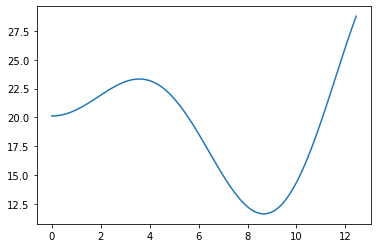

In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x = np.arange(0, 100)
x = x / 100.0 * np.pi * 4
y = x * np.sin(x / 1.764) + 20.1234
plt.plot(x, y)

In [17]:
schema = typ.StructType(
    [typ.StructField('continuous_var', typ.DoubleType(), False)]
)
data = spark.createDataFrame([[float(e)] for e in y], schema=schema)

# data = spark.createDataFrame([[float(e), ] for e in y], schema=schema)

In [19]:
data.show(5)

+------------------+
|    continuous_var|
+------------------+
|           20.1234|
|20.132344452369832|
|20.159087064491775|
|20.203356291885854|
| 20.26470185735763|
+------------------+
only showing top 5 rows



Use the `QuantileDiscretizer` model to split our continuous variable into 5 buckets (see the `numBuckets` parameter).

In [20]:
# QuantileDiscretizer将连续变量划分到5个分类级别
discretizer = ft.QuantileDiscretizer(
    numBuckets=5,
    inputCol='continuous_var',
    outputCol='discretized'
)

Let's see what we got.

In [21]:
data_discretized = discretizer.fit(data).transform(data)

data_discretized.show(5)

+------------------+-----------+
|    continuous_var|discretized|
+------------------+-----------+
|           20.1234|        2.0|
|20.132344452369832|        2.0|
|20.159087064491775|        2.0|
|20.203356291885854|        2.0|
| 20.26470185735763|        2.0|
+------------------+-----------+
only showing top 5 rows



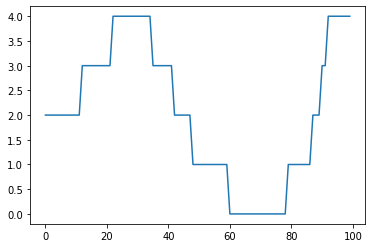

In [25]:
# 经过离散化处理的函数, 使用OneHot 进行编码来使用
pdf = data_discretized.toPandas()
plt.plot(pdf['discretized'])  

In [26]:
data_discretized \
    .groupby('discretized')\
    .mean('continuous_var')\
    .sort('discretized')\
    .collect()

[Row(discretized=0.0, avg(continuous_var)=12.314360733007915),
 Row(discretized=1.0, avg(continuous_var)=16.046244793347466),
 Row(discretized=2.0, avg(continuous_var)=20.25079947835259),
 Row(discretized=3.0, avg(continuous_var)=22.040988218437327),
 Row(discretized=4.0, avg(continuous_var)=24.264824657002865)]

#### Standardizing continuous variables

Create a vector representation of our continuous variable (as it is only a single float)


In [27]:
# 从float数值 转为向量
vectorizer = ft.VectorAssembler(
    inputCols=['continuous_var'],
    outputCol='continuous_vec'
)

Build a `normalizer` and a `pipeline`.

In [29]:
normalizer = ft.StandardScaler(
    inputCol=vectorizer.getOutputCol(),
    outputCol='normalized',
    withMean=True,
    withStd=True
)
pipeline = Pipeline(stages=[vectorizer, normalizer])
data_standardized = pipeline.fit(data).transform(data)

In [52]:
data_standardized.show(5)

+------------------+--------------------+--------------------+
|    continuous_var|      continuous_vec|          normalized|
+------------------+--------------------+--------------------+
|           20.1234|           [20.1234]|[0.2342913955450253]|
|20.132344452369832|[20.132344452369832]|[0.23630959828688...|
|20.159087064491775|[20.159087064491775]|[0.2423437310517911]|
|20.203356291885854|[20.203356291885854]|[0.2523325232564452]|
| 20.26470185735763| [20.26470185735763]|[0.2661743755372585]|
+------------------+--------------------+--------------------+
only showing top 5 rows



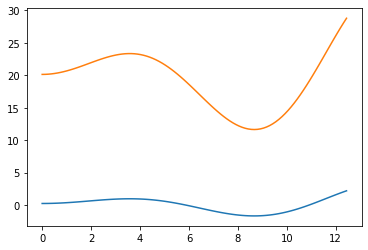

In [51]:
normalized_data = data_standardized.select("normalized").rdd.map(lambda x: x[0])
plt.plot(x, normalized_data.collect())
plt.plot(x, y)

### Classification

We will now use the `RandomForestClassfier` to model the chances of survival for an infant.

First, we need to cast the label feature to `DoubleType`.

In [53]:
import pyspark.sql.functions as func

births = births.withColumn(
    'INFANT_ALIVE_AT_REPORT',
    func.col('INFANT_ALIVE_AT_REPORT').cast(typ.DoubleType())
)

births_train, births_test = births.randomSplit([0.7, 0.3], seed=777)


We are ready to build our model.

In [60]:
classifier = cl.RandomForestClassifier(
    numTrees=5,
    maxDepth=5,
    labelCol='INFANT_ALIVE_AT_REPORT'
)
pipeline = Pipeline(stages=[encoder, features_creator, classifier])
model = pipeline.fit(births_train)
test = model.transform(births_test)

Let's now see how the `RandomForestClassifier` model performs compared to the `LogisticRegression`.

In [63]:
evaluator = ev.BinaryClassificationEvaluator(
    labelCol='INFANT_ALIVE_AT_REPORT')
print(evaluator.evaluate(test, 
    {evaluator.metricName: "areaUnderROC"}))
print(evaluator.evaluate(test, 
    {evaluator.metricName: "areaUnderPR"}))

0.7558112778836876
0.6998465750651709


Let's test how well would one tree do, then.

In [65]:
classifier = cl.DecisionTreeClassifier(
    maxDepth=5, 
    labelCol='INFANT_ALIVE_AT_REPORT')
pipeline = Pipeline(stages=[
        encoder,
        features_creator, 
        classifier]
)

model = pipeline.fit(births_train)
test = model.transform(births_test)

evaluator = ev.BinaryClassificationEvaluator(
    labelCol='INFANT_ALIVE_AT_REPORT')
print(evaluator.evaluate(test, 
     {evaluator.metricName: "areaUnderROC"}))
print(evaluator.evaluate(test, 
     {evaluator.metricName: "areaUnderPR"}))

0.7168481190766106
0.713068839628991


### Clustering

In this example we will use k-means model to find similarities in the births data.

In [66]:
import pyspark.ml.clustering as cluster

kmeans = cluster.KMeans(k=5, featuresCol='features')
pipeline = Pipeline(stages=[encoder, features_creator, kmeans])
model = pipeline.fit(births_train)

Having estimated the model, let's see if we can find some differences between clusters.

In [67]:
test = model.transform(births_test)
test.groupby('prediction').agg({"*": 'count', 'MOTHER_HEIGHT_IN':'avg'}).collect()

[Row(prediction=1, avg(MOTHER_HEIGHT_IN)=68.11134453781513, count(1)=476),
 Row(prediction=3, avg(MOTHER_HEIGHT_IN)=66.23484848484848, count(1)=264),
 Row(prediction=4, avg(MOTHER_HEIGHT_IN)=65.39210309843708, count(1)=3647),
 Row(prediction=2, avg(MOTHER_HEIGHT_IN)=84.2135922330097, count(1)=412),
 Row(prediction=0, avg(MOTHER_HEIGHT_IN)=63.90330874133691, count(1)=8946)]

In the field of NLP, problems such as topic extract rely on clustering to detect documents with similar topics. First, let's create our dataset.

In [68]:
text_data = spark.createDataFrame([
    ['''To make a computer do anything, you have to write a 
    computer program. To write a computer program, you have 
    to tell the computer, step by step, exactly what you want 
    it to do. The computer then "executes" the program, 
    following each step mechanically, to accomplish the end 
    goal. When you are telling the computer what to do, you 
    also get to choose how it's going to do it. That's where 
    computer algorithms come in. The algorithm is the basic 
    technique used to get the job done. Let's follow an 
    example to help get an understanding of the algorithm 
    concept.'''],
    ['''Laptop computers use batteries to run while not 
    connected to mains. When we overcharge or overheat 
    lithium ion batteries, the materials inside start to 
    break down and produce bubbles of oxygen, carbon dioxide, 
    and other gases. Pressure builds up, and the hot battery 
    swells from a rectangle into a pillow shape. Sometimes 
    the phone involved will operate afterwards. Other times 
    it will die. And occasionally—kapow! To see what's 
    happening inside the battery when it swells, the CLS team 
    used an x-ray technology called computed tomography.'''],
    ['''This technology describes a technique where touch 
    sensors can be placed around any side of a device 
    allowing for new input sources. The patent also notes 
    that physical buttons (such as the volume controls) could 
    be replaced by these embedded touch sensors. In essence 
    Apple could drop the current buttons and move towards 
    touch-enabled areas on the device for the existing UI. It 
    could also open up areas for new UI paradigms, such as 
    using the back of the smartphone for quick scrolling or 
    page turning.'''],
    ['''The National Park Service is a proud protector of 
    America’s lands. Preserving our land not only safeguards 
    the natural environment, but it also protects the 
    stories, cultures, and histories of our ancestors. As we 
    face the increasingly dire consequences of climate 
    change, it is imperative that we continue to expand 
    America’s protected lands under the oversight of the 
    National Park Service. Doing so combats climate change 
    and allows all American’s to visit, explore, and learn 
    from these treasured places for generations to come. It 
    is critical that President Obama acts swiftly to preserve 
    land that is at risk of external threats before the end 
    of his term as it has become blatantly clear that the 
    next administration will not hold the same value for our 
    environment over the next four years.'''],
    ['''The National Park Foundation, the official charitable 
    partner of the National Park Service, enriches America’s 
    national parks and programs through the support of 
    private citizens, park lovers, stewards of nature, 
    history enthusiasts, and wilderness adventurers. 
    Chartered by Congress in 1967, the Foundation grew out of 
    a legacy of park protection that began over a century 
    ago, when ordinary citizens took action to establish and 
    protect our national parks. Today, the National Park 
    Foundation carries on the tradition of early park 
    advocates, big thinkers, doers and dreamers—from John 
    Muir and Ansel Adams to President Theodore Roosevelt.'''],
    ['''Australia has over 500 national parks. Over 28 
    million hectares of land is designated as national 
    parkland, accounting for almost four per cent of 
    Australia's land areas. In addition, a further six per 
    cent of Australia is protected and includes state 
    forests, nature parks and conservation reserves.National 
    parks are usually large areas of land that are protected 
    because they have unspoilt landscapes and a diverse 
    number of native plants and animals. This means that 
    commercial activities such as farming are prohibited and 
    human activity is strictly monitored.''']
], ['documents'])

First, we will once again use the `RegexTokenizer` and the `StopWordsRemover` models.

In [72]:
tokenizer = ft.RegexTokenizer(
    inputCol='documents', 
    outputCol='input_arr', 
    pattern='\s+|[,.\"]')

stopwords = ft.StopWordsRemover(
    inputCol=tokenizer.getOutputCol(), 
    outputCol='input_stop')

Next in our pipeline is the `CountVectorizer`.

In [69]:
df = spark.createDataFrame(
   [(0, ["a", "b", "c"]), (1, ["a", "b", "b", "c", "a"])],
   ["label", "raw"])
# 计算文档中的单词并返回一个计数向量
cv = ft.CountVectorizer(inputCol='raw', outputCol='vectors')
model = cv.fit(df)
model.transform(df).show(truncate=False)

+-----+---------------+-------------------------+
|label|raw            |vectors                  |
+-----+---------------+-------------------------+
|0    |[a, b, c]      |(3,[0,1,2],[1.0,1.0,1.0])|
|1    |[a, b, b, c, a]|(3,[0,1,2],[2.0,2.0,1.0])|
+-----+---------------+-------------------------+



In [70]:
sorted(model.vocabulary)

['a', 'b', 'c']

In [73]:

stringIndexer = ft.CountVectorizer(
    inputCol=stopwords.getOutputCol(), 
    outputCol="input_indexed")

tokenized = stopwords \
    .transform(
        tokenizer\
            .transform(text_data)
    )
    
stringIndexer \
    .fit(tokenized)\
    .transform(tokenized)\
    .select('input_indexed')\
    .take(2)

[Row(input_indexed=SparseVector(257, {2: 7.0, 6: 1.0, 9: 3.0, 11: 3.0, 13: 3.0, 14: 1.0, 22: 1.0, 30: 1.0, 31: 2.0, 35: 2.0, 40: 1.0, 43: 1.0, 49: 1.0, 59: 1.0, 64: 1.0, 76: 1.0, 81: 1.0, 90: 1.0, 98: 1.0, 106: 1.0, 124: 1.0, 129: 1.0, 145: 1.0, 150: 1.0, 156: 1.0, 163: 1.0, 173: 1.0, 202: 1.0, 204: 1.0, 210: 1.0, 250: 1.0, 253: 1.0, 256: 1.0})),
 Row(input_indexed=SparseVector(257, {20: 2.0, 21: 1.0, 22: 1.0, 26: 2.0, 37: 2.0, 38: 2.0, 45: 1.0, 47: 1.0, 53: 1.0, 56: 1.0, 60: 1.0, 61: 1.0, 63: 1.0, 66: 1.0, 74: 1.0, 79: 1.0, 93: 1.0, 103: 1.0, 104: 1.0, 110: 1.0, 113: 1.0, 118: 1.0, 119: 1.0, 121: 1.0, 123: 1.0, 132: 1.0, 133: 1.0, 135: 1.0, 146: 1.0, 147: 1.0, 177: 1.0, 178: 1.0, 185: 1.0, 186: 1.0, 190: 1.0, 192: 1.0, 197: 1.0, 198: 1.0, 201: 1.0, 207: 1.0, 226: 1.0, 228: 1.0, 233: 1.0, 241: 1.0, 244: 1.0, 247: 1.0, 252: 1.0}))]

We will use the `LDA` model - the Latent Dirichlet Allocation model - to extract the topics.

In [74]:
clustering = cluster.LDA(k=2, optimizer='online', featuresCol=stringIndexer.getOutputCol())

Put these puzzles together.

In [75]:
pipeline = Pipeline(stages=[
        tokenizer, 
        stopwords,
        stringIndexer, 
        clustering]
)

Let's see if we have properly uncovered the topics.

In [79]:
topics = pipeline.fit(text_data).transform(text_data)
topics.select("topicDistribution").collect()

[Row(topicDistribution=DenseVector([0.7952, 0.2048])),
 Row(topicDistribution=DenseVector([0.9856, 0.0144])),
 Row(topicDistribution=DenseVector([0.9652, 0.0348])),
 Row(topicDistribution=DenseVector([0.2579, 0.7421])),
 Row(topicDistribution=DenseVector([0.0083, 0.9917])),
 Row(topicDistribution=DenseVector([0.2807, 0.7193]))]

### Regression

In this section we will try to predict the `MOTHER_WEIGHT_GAIN`.

In [80]:
features = ['MOTHER_AGE_YEARS','MOTHER_HEIGHT_IN',
            'MOTHER_PRE_WEIGHT','DIABETES_PRE',
            'DIABETES_GEST','HYP_TENS_PRE', 
            'HYP_TENS_GEST', 'PREV_BIRTH_PRETERM',
            'CIG_BEFORE','CIG_1_TRI', 'CIG_2_TRI', 
            'CIG_3_TRI'
           ]

First, we will collate all the features together and use the `ChiSqSelector` to select only the top 6 most important features.

In [82]:
features_creator = ft.VectorAssembler(
    inputCols=[col for col in features[1:]],
    outputCol='features'
)
selector = ft.ChiSqSelector(
    numTopFeatures=6,
    outputCol="selected_features",
    labelCol='MOTHER_WEIGHT_GAIN'
)

In order to predict the weight gain we will use the gradient boosted trees regressor.

In [83]:
import pyspark.ml.regression as reg

regressor = reg.GBTRegressor(
    maxIter=15,
    maxDepth=3,
    labelCol='MOTHER_WEIGHT_GAIN'
)

Finally, again, we put it all together into a `Pipeline`.

In [84]:
pipeline = Pipeline(stages=[
        featuresCreator, 
        selector,
        regressor])

weightGain = pipeline.fit(births_train)

Having created the `weightGain` model, let's see if it performs well on our testing data.

In [85]:
evaluator = ev.RegressionEvaluator(
    predictionCol="prediction", 
    labelCol='MOTHER_WEIGHT_GAIN')

print(evaluator.evaluate(
     weightGain.transform(births_test), 
    {evaluator.metricName: 'r2'}))

0.4844738226232578
